In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Funcion Verdadera
def true_function(x):
    return np.sin(2 * np.pi * x) + 0.5 * x**2

N = 80
x = np.sort(np.random.uniform(0, 1, N))
y = true_function(x) + np.random.normal(0, 0.25, N)

x_test = np.linspace(0, 1, 200)
y_true = true_function(x_test)

In [14]:
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

def nadaraya_watson(x_new, x_train, y_train, h):
    """
    Nadaraya-Wastson Kernel regression
    h: bandwidth
    """

    if h <= 0:
        h = 1e-6 # evitar la division por 0
    dist = (x_new - x_train) / h
    weights = gaussian_kernel(dist)
    weights_sum = weights.sum()
    if weights_sum == 0:
        return np.mean(y_train) # fallback
    weights /= weights_sum
    return np.sum(weights * y_train)

    weights = gaussian_kernel((x_new - x_train) / h)
    weights /= weights.sum()  # normalizar
    y_pred = np.sum(weights * y_train)
    return y_pred

<function matplotlib.pyplot.show(close=None, block=None)>

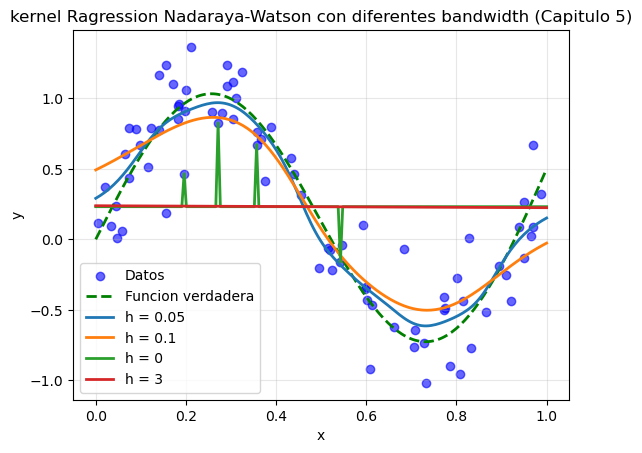

In [15]:
h_values = [0.05, 0.1, 0,3] # bandwidths pequeños, medianos, grandes

plt.Figure(figsize=(12, 8))

plt.scatter(x, y, color='blue', alpha= 0.6, label='Datos')
plt.plot(x_test, y_true, 'g--', linewidth=2, label='Funcion verdadera')

for h in h_values:
    y_pred = np.array([nadaraya_watson(xi, x, y, h) for xi in x_test])
    plt.plot(x_test, y_pred, linewidth=2, label=f'h = {h}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('kernel Ragression Nadaraya-Watson con diferentes bandwidth (Capitulo 5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show    

In [16]:
def local_regression(x_new, x_train, y_train, h):
    weights = gaussian_kernel((x_new - x_train) / h)
    weights /= weights.sum() + 1e-10  # evitar division por cero

    # Regresion lineal ponderada local
    X_loc = np.column_stack((np.ones(len(x_train)), x_train))
    W = np.diag(weights)
    XtWX = X_loc.T @ W @ X_loc
    XtWy = X_loc.T @ W @ y_train 

    if np.linalg.det(XtWX) < 1e-10:
        return np.mean(y_train) # fallback
    
    betas_loc = np.linalg.solve(XtWX, XtWy)
    y_pred = betas_loc[0] + betas_loc[1] * x_new
    return y_pred

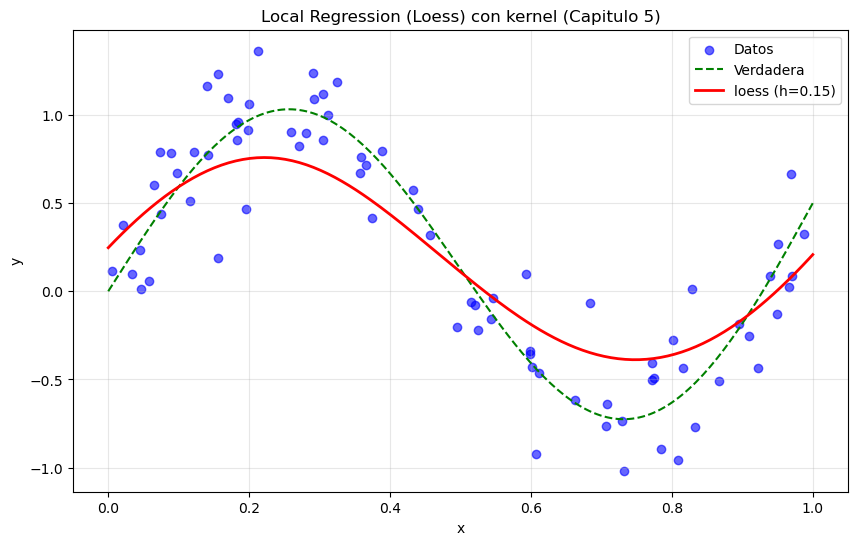

In [17]:
h_loess = 0.15 # Prueba 0.1, 0.2, 04

y_loess = np.array([local_regression(xi, x, y, h_loess) for xi in x_test])

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.6, label='Datos')
plt.plot(x_test, y_true, 'g--', label='Verdadera')
plt.plot(x_test, y_loess, 'r-', linewidth=2, label=f'loess (h={h_loess})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Local Regression (Loess) con kernel (Capitulo 5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
from sklearn.model_selection import LeaveOneOut

h_candidates = np.linspace(0.05, 0.5, 10)
mse_loocv = np.zeros(len(h_candidates))

loo = LeaveOneOut()
for i, h in enumerate(h_candidates):
    mse_total = 0
    for train_idx, test_idx in loo.split(x):
        x_train, y_train = x[train_idx], y[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]
        y_pred = nadaraya_watson(x_test[0], x_train, y_train, h)
        mse_total += (y_test[0] - y_pred)**2
    mse_loocv[i] = mse_total / N

best_h_idx = np.argmin(mse_loocv)
best_h = h_candidates[best_h_idx]
best_mse = mse_loocv[best_h_idx]

print(f"Mejor h por LOOCV: {best_h: 3f} con MSE ≈ {best_mse:.3f}")


Mejor h por LOOCV:  0.050000 con MSE ≈ 0.072


<function matplotlib.pyplot.show(close=None, block=None)>

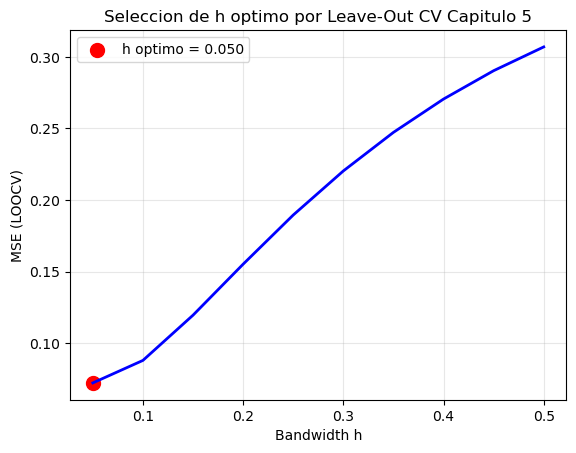

In [19]:
plt.Figure(figsize=(8, 5))
plt.plot(h_candidates, mse_loocv, 'b-', linewidth=2)
plt.scatter(best_h, best_mse, color='red', s=100, label=f'h optimo = {best_h:.3f}')
plt.xlabel('Bandwidth h')
plt.ylabel('MSE (LOOCV)')
plt.title('Seleccion de h optimo por Leave-Out CV Capitulo 5')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show